In [1]:
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson  
from statsmodels.genmod.families.links import identity, log
from pandas import DataFrame as df 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF

from scipy.stats import multivariate_normal

import matplotlib 

font = {'size'   : 20}
matplotlib.rc('font', **font)  # pass in the font dict as kwargs

np.random.seed(40)

In [2]:
duration = 200  # second
sampling_frequency = 500

n_samples = duration * sampling_frequency
time_base = np.arange(n_samples) / sampling_frequency

run_speed = 15  # cm / s
track_length = 100  # cm

freq = 1 / (2* track_length / run_speed)

position = np.sin(freq*2*np.pi*time_base - np.pi/2) * (track_length/2) + track_length/2



In [3]:
def simulate_poisson_spikes(rate, sampling_freq):
    return np.random.poisson(rate / sampling_frequency) > 0

def simulate_placecell_firing_rate(means, position, max_rate=15, variance=10, directional='outbound'):
    firing_rate = multivariate_normal(means, variance).pdf(position)
    firing_rate /= firing_rate.max()
    firing_rate *= max_rate 
    if directional == 'outbound':
        diff = np.diff(position, append=0)
        firing_rate[diff < 0] = 0
    elif directional == 'inbound':
        diff = np.diff(position, append=0)
        firing_rate[diff > 0] = 0
    return firing_rate

def simulate_place_cell_spikes(means, position, max_rate=15, variance=36, sampling_frequency=500):
    firing_rate = simulate_placecell_firing_rate(means, position, max_rate, variance)
    return simulate_poisson_spikes(firing_rate, sampling_frequency)


In [4]:
spikes = simulate_place_cell_spikes(40, position, sampling_frequency=sampling_frequency)

spike_times = time_base[spikes]

len(spike_times)

143

Text(0, 0.5, 'Position (cm)')

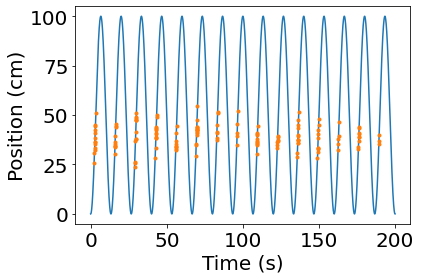

In [5]:
plt.plot(time_base, position)
plt.plot(spike_times, position[spikes],'.')

plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')

Text(0, 0.5, 'Firing rate (Hz)')

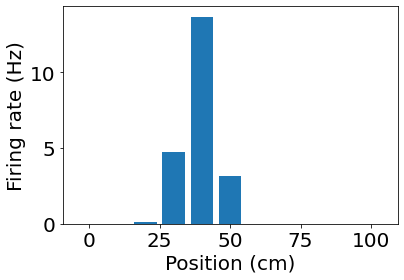

In [6]:
# plot place field 


bin_edges = np.arange(-5, 106, 10)
spikehist = np.histogram(position[spikes], bin_edges)[0] 
occupancy = np.histogram(position, bin_edges)[0]*0.001 
plt.bar(np.linspace(0, 100, 11), spikehist/occupancy, width=8)  
plt.xlabel('Position (cm)')
plt.ylabel('Firing rate (Hz)')


In [7]:

spiketrain = np.histogram(spike_times, bins = len(time_base), range = (time_base[0], time_base[-1]))[0] 
spikeindex = np.where(spiketrain!=0)[0]

# fitting a poisson-GLM
# Create a dataframe of predictors that includes position and a constant term
predictors = df(data={'Intercept': np.ones_like(position), 'X': position})

# GLM model with Poisson family and identity link function
model1 = sm.GLM(spiketrain, predictors, family=Poisson(identity()))
model1_results = model1.fit() # Fit model to our data
b1 = model1_results.params
print('b1:')
print(b1)


/home/jgeerts/miniconda3/envs/analysis/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


b1:
Intercept    0.002901
X           -0.000030
dtype: float64


## Model fitting
Let's use a poisson-GLM to fit a model of the shape:$$\log \lambda(t) = \beta_0 + \beta_1 x(t) + \beta_2 x(t)^2 $$

This can be rewritten as a gaussian form $\lambda(t)= \alpha \exp \left( - \frac{(x-\mu)}{2 \sigma^2} \right)$, with: 

$$ \mu = -\frac{\beta_1}{2\beta_2}$$
$$\sigma^2 = - \frac{1}{2\beta_2}$$
$$\alpha = \exp\left(\beta_0 - \frac{\beta_1^2}{4 \beta_2}\right)$$

In [8]:
predictors = df(data={                                     # Create a dataframe of predictors
  'Intercept': np.ones_like(position),
  'X': position,
  'X2': position**2
  })

# GLM model with Poisson family and identity link function
model3 = sm.GLM(spiketrain, predictors, family=Poisson())  # Create the model
model3_results = model3.fit()                              # Fit model to our data
b3 = model3_results.params                                 # Get the predicted coefficient vector

dev3= model3_results.deviance         # Deviance from Model 3



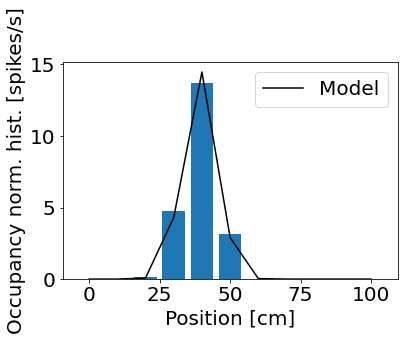

In [9]:
bins = np.linspace(0, 100, 11)
plt.bar(bins, spikehist / occupancy, width=8)                  # Plot results as bars.
plt.plot(bins,                                                 # Plot model.
     np.exp(b3[0] + b3[1] * bins + b3[2] * bins**2) * 1000,
     'k', label='Model')
plt.xlabel('Position [cm]')                                    # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.legend()


## Add direction 
New model including direction $\theta$:$$\log \lambda(t) = \beta_0 + \beta_1 x(t) + \beta_2 x(t)^2 + \beta_3 \theta(t) $$

In [10]:
# now add direction
increasing = np.where(np.diff(position.flatten()) > 0)[0]  # Array for if X(t) increased since last step
direction = np.zeros_like(position).astype(int)  # Create a direction array the same size as X
direction[increasing] = 1  # Set direction to 1 when X is increasing

In [11]:
#Fit model with direction, and return estimates and useful statistics.
predictors['direction'] = direction #Add column for direction
# GLM model with Poisson family and default (log) link function
model4 = sm.GLM(spiketrain, predictors, family=Poisson()) 
model4_results = model4.fit()       # Fit model to our data
b4 = model4_results.params          # Get the predicted coefficient vector
print(b4)

Intercept   -34.836770
X             1.100745
X2           -0.014001
direction     9.662856
dtype: float64


In [12]:
dev4 = model4_results.deviance         # Deviance from Model 4
dAIC = (dev3 + 2 * 3) - (dev4 + 2 * 4) # Difference in AIC between Models 3 & 4.
print(dAIC)


196.21894659724035


In [13]:
p = 1 - chi2.cdf(dev3 - dev4, 1)  # Compare Models 3 and 4, nested GLMs.
print(p)

0.0


In [14]:
# For Model 4, compute 95% CI for last parameter,
CI_beta3 = [b4[3] - 2*model4_results.bse[3], b4[3] + 2*model4_results.bse[3]]
p_beta3 = model4_results.pvalues[3]  # and significance level.
print('CI_beta3: ', CI_beta3)
print('p_beta3: ', p_beta3)


CI_beta3:  [-0.7268053662325009, 20.052516810996213]
p_beta3:  0.06287270184797515


Text(0.5, 1.0, 'Model 4 KS plot')

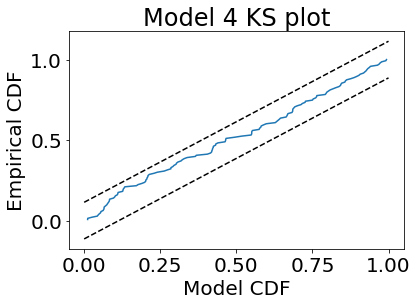

In [15]:
lambda4 = np.exp(b4[0] + b4[1]*position + b4[2]*position**2 + b4[3]*direction)

Z = [sum(lambda4[a:b])  # Compute the rescaled waiting time
     for a, b in zip(np.hstack((0, spikeindex[:-1])), spikeindex)]  # ... for each spike interval

N = len(Z)

ecdf = ECDF(Z)                                   # Define empirical cdf
mCDF = 1 - np.exp(-ecdf.x)                          # ... and model cdf

plt.plot(mCDF, ecdf.y)                               # create KS plot 
plt.plot([0,1], [0,1]+1.36/np.sqrt(N),'k--', ms = 2)    # Upper confidence bound
plt.plot([0,1], [0,1]-1.36/np.sqrt(N),'k--', ms = 2)    # Lower confidence bound
plt.xlabel('Model CDF')                              # Label the axes.
plt.ylabel('Empirical CDF')
plt.title('Model 4 KS plot')


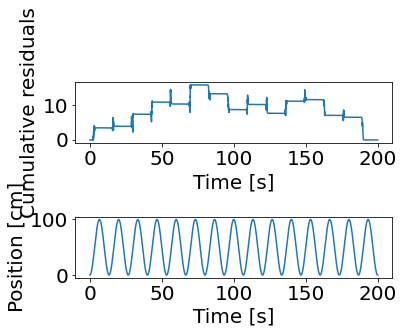

In [16]:
fig, (ax1, ax2) = plt.subplots(2)
plt.sca(ax1)
R = np.cumsum(model4_results.resid_response)  # Cumulative sum of Model 4 residuals.
plt.plot(time_base,R)                                  # Plot it.
plt.xlabel('Time [s]')
plt.ylabel('Cumulative residuals')

plt.sca(ax2)


plt.plot(time_base, position)
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')

plt.tight_layout()

In [17]:
# compute maximum likelihood estimates of
mu = -b4[1] / (2 * b4[2])                 # place field center
sigma = np.sqrt(-1 / (2 * b4[2]))            # place field size
alpha = np.exp(b4[0] - b4[1]**2 / (4 * b4[2]))  # max firing rate

print('mu: ', mu)
print('sigma: ', sigma)
print('alpha: ', alpha)


mu:  39.309236850562
sigma:  5.975908708543321
alpha:  1.846815042909651e-06


In [18]:
alpha

1.846815042909651e-06

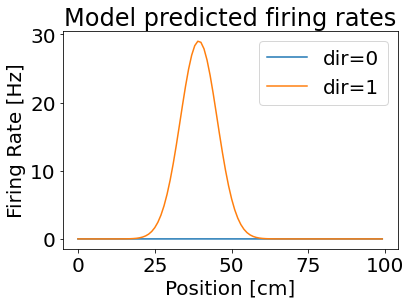

In [19]:
xs = np.arange(100)

# Create an array with [constant, position, position squared, direction] terms
dir_0 = np.array([np.ones_like(xs), xs, xs**2, np.zeros_like(xs)]).T  # ... for when the direction is 0
dir_1 = np.array([np.ones_like(xs), xs, xs**2, np.ones_like(xs)]).T  # ... and for when direction is 1
lambda4_0 = model4_results.predict(dir_0)*1000  # Predict the firing rate when the direction is 0
lambda4_1 = model4_results.predict(dir_1)*1000  # ... and when the direction is one

plt.plot(xs, lambda4_0, label="dir=0")  # Plot results
plt.plot(xs, lambda4_1, label="dir=1")
plt.xlabel('Position [cm]')
plt.ylabel('Firing Rate [Hz]')
plt.title('Model predicted firing rates')
plt.legend()


In [22]:
from copy import deepcopy

## Generalise to 2D

In [163]:
# first get some 2D running trajectory 
import sys
sys.path.append('..')

from replay_analysis.core.tint import get_trial

from definitions import load_experiment_info_guifen


duration = 2000  # second



exp_info = load_experiment_info_guifen()
a = exp_info.iloc[0].Animal
d = exp_info.iloc[0].ExperimentN
trial_data = get_trial(a, t=2, d=d, p='guifen')

samp_rate = trial_data.pos_samp_rate



xy = trial_data.xy[:, :int(duration*samp_rate)]

n_samples = xy.shape[1]
time_base = np.arange(n_samples) / samp_rate


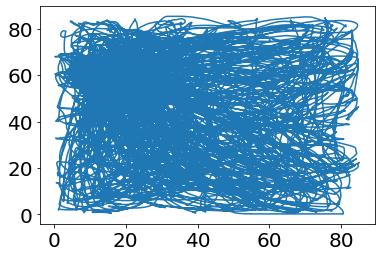

In [164]:
plt.plot(xy[0], xy[1])

In [165]:
def simulate_placecell_firing_rate(means, position, max_rate=15, variance=10, directional='outbound'):
    firing_rate = multivariate_normal(means, variance).pdf(position)
    firing_rate /= firing_rate.max()
    firing_rate *= max_rate 
    return firing_rate



In [166]:
firing_field = np.array([20,50])

simulate_placecell_firing_rate(firing_field, xy.T, directional=None).shape

(90050,)

In [167]:
spikes = simulate_place_cell_spikes(firing_field,  xy.T, max_rate=15, variance=20, sampling_frequency=samp_rate)

In [168]:
spike_times = time_base[spikes]

len(spike_times)

151

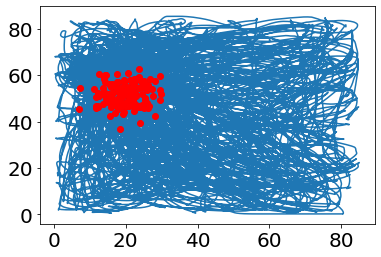

In [169]:
plt.plot(xy[0], xy[1])

plt.scatter(*xy[:,spikes], color='r', zorder=3)

In [170]:
spiketrain = np.histogram(spike_times, bins=len(time_base), range=(time_base[0], time_base[-1]))[0] 
spikeindex = np.where(spiketrain!=0)[0]

In [185]:
xy[:,spikeindex].mean(1)

array([19.81179806, 51.72497058])

In [178]:
spiketrain.shape

(90050,)

In [186]:
predictors = df(data={                                     # Create a dataframe of predictors
  'Intercept': np.ones_like(xy[0]),
  'X': xy[0],
  'X2': xy[0]**2,
  'Y': xy[1],
  'Y2': xy[1]**2
  })

# GLM model with Poisson family and identity link function
model2d = sm.GLM(spiketrain, predictors, family=Poisson())  # Create the model
model2d_results = model2d.fit()                              # Fit model to our data
b2d = model2d_results.params                                 # Get the predicted coefficient vector

dev2d= model2d.deviance         # Deviance from Model 3



In [187]:
b2d

Intercept   -54.664538
X             0.580683
X2           -0.015545
Y             1.804554
Y2           -0.017960
dtype: float64

In [194]:
x_bins = np.arange(0, 80, .5)
y_bins = np.arange(0, 80, .5)

model_ratemap = np.zeros((len(x_bins), len(y_bins)))

for i, x in enumerate(x_bins):
    for j, y in enumerate(y_bins):
        fr = np.exp(b2d[0] + b2d[1]*x + b2d[2] * x**2 + b2d[3]*y + b2d[4]* y**2)*1000
        if fr>19:
            print('x = {},  y= {}'.format(x,y))
        model_ratemap[i, j] = fr 

x = 17.0,  y= 50.0
x = 17.0,  y= 50.5
x = 17.5,  y= 49.0
x = 17.5,  y= 49.5
x = 17.5,  y= 50.0
x = 17.5,  y= 50.5
x = 17.5,  y= 51.0
x = 18.0,  y= 49.0
x = 18.0,  y= 49.5
x = 18.0,  y= 50.0
x = 18.0,  y= 50.5
x = 18.0,  y= 51.0
x = 18.0,  y= 51.5
x = 18.5,  y= 49.0
x = 18.5,  y= 49.5
x = 18.5,  y= 50.0
x = 18.5,  y= 50.5
x = 18.5,  y= 51.0
x = 18.5,  y= 51.5
x = 19.0,  y= 49.0
x = 19.0,  y= 49.5
x = 19.0,  y= 50.0
x = 19.0,  y= 50.5
x = 19.0,  y= 51.0
x = 19.0,  y= 51.5
x = 19.5,  y= 49.0
x = 19.5,  y= 49.5
x = 19.5,  y= 50.0
x = 19.5,  y= 50.5
x = 19.5,  y= 51.0
x = 19.5,  y= 51.5
x = 20.0,  y= 49.5
x = 20.0,  y= 50.0
x = 20.0,  y= 50.5
x = 20.0,  y= 51.0


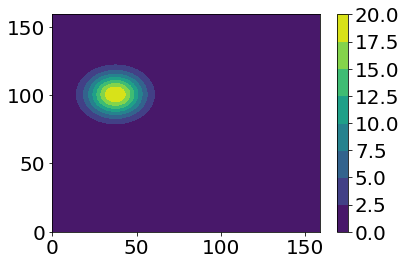

In [203]:
plt.contourf(model_ratemap.T)
plt.colorbar()

# for fitting any shape elliptical fields, we need to make one more adaptation 


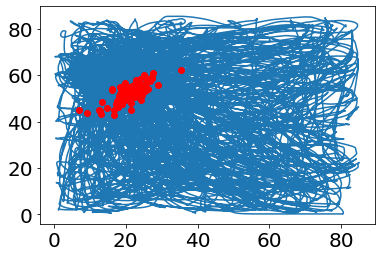

In [232]:
firing_field = np.array([20 ,50])

cov_mat = np.array([[20, 15], [15, 20]])

#multivariate_normal(firing_field, cov_mat).pdf(xy.T)

spikes = simulate_place_cell_spikes(firing_field,  xy.T, max_rate=15, variance=cov_mat, sampling_frequency=samp_rate)
spike_times = time_base[spikes]

plt.plot(xy[0], xy[1])

plt.scatter(*xy[:,spikes], color='r', zorder=3)

In [233]:


predictors = df(data={                                     # Create a dataframe of predictors
  'Intercept': np.ones_like(xy[0]),
  'X': xy[0],
  'X2': xy[0]**2,
  'Y': xy[1],
  'Y2': xy[1]**2,
  'XY': xy[0] * xy[1]
  })

# GLM model with Poisson family and identity link function
model2d = sm.GLM(spiketrain, predictors, family=Poisson())  # Create the model
model2d_results = model2d.fit()                              # Fit model to our data
b2d = model2d_results.params                                 # Get the predicted coefficient vector

dev2d = model2d_results.deviance         # Deviance from Model 3



In [234]:
predictors

,Intercept,X,X2,Y,Y2,XY
0,1.0,23.123018,534.673955,61.517852,3784.446149,1422.478397
1,1.0,23.123018,534.673955,61.517852,3784.446149,1422.478397
2,1.0,23.123018,534.673955,61.517852,3784.446149,1422.478397
3,1.0,23.123018,534.673955,61.517852,3784.446149,1422.478397
4,1.0,23.123018,534.673955,61.517852,3784.446149,1422.478397
...,...,...,...,...,...,...
90045,1.0,27.662404,765.208609,60.772416,3693.286603,1681.111152
90046,1.0,27.773516,771.368185,60.639083,3677.098420,1684.160543
90047,1.0,27.862404,776.313560,60.505750,3660.945789,1685.835656
90048,1.0,27.940282,780.659363,60.372417,3644.828718,1686.822358


In [250]:
x_bins = np.arange(0, 80, .5)
y_bins = np.arange(0, 80, .5)

model_ratemap = np.zeros((len(x_bins), len(y_bins)))

xs = []
ys = []

for i, x in enumerate(x_bins):
    for j, y in enumerate(y_bins):
        fr = np.exp(b2d[0] + b2d[1]*x + b2d[2] * x**2 + b2d[3]*y + b2d[4]* y**2 + b2d[5]*x*y)*1000
        if fr>18.2:
            print('x = {},  y= {}'.format(x,y))
            xs.append(x)
            ys.a

        model_ratemap[i, j] = fr 


x = 19.5,  y= 49.5
x = 19.5,  y= 50.0
x = 20.0,  y= 49.0
x = 20.0,  y= 49.5
x = 20.0,  y= 50.0
x = 20.0,  y= 50.5
x = 20.5,  y= 49.0
x = 20.5,  y= 49.5
x = 20.5,  y= 50.0
x = 20.5,  y= 50.5
x = 21.0,  y= 49.0
x = 21.0,  y= 49.5
x = 21.0,  y= 50.0
x = 21.5,  y= 49.5


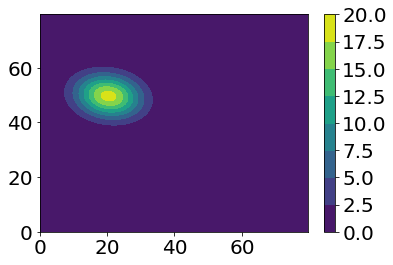

In [253]:
plt.contourf(y_bins, x_bins, model_ratemap.T)
plt.colorbar()